#### Simple PPO Agent (CityLearn)

In [1]:
# Basic imports & versions
import sys, os, json, time, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-25 17:50:09.857108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 17:50:09.870790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756137009.885894 3572326 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756137009.890256 3572326 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756137009.902135 3572326 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [2]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10

In [3]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity'], drop_predictions=False)

env = CityLearnEnv(schema, central_agent=True) # create env
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_17-50-15'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 6
Electrical storage capacity: {'Building_1': 4.0, 'Building_2': 4.0, 'Building_3': 3.3, 'Building_4': 3.3, 'Building_5': 4.0, 'Building_6': 3.3}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (6,), float32)]
Number of Observations: 20


#### Build & Train PPO

In [4]:
# old:
# env = Monitor(CityLearnPPOWrapper(env))

from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

log_dir = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
os.makedirs(log_dir, exist_ok=True)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = Monitor(train_env, filename=os.path.join(log_dir, "monitor.csv"))
logger = PPOTrainLogger()
TOTAL_TIMESTEPS = 2208 * 40

model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=0, # seed for pseudo random generators
    device='cpu', # ppo is intended to run on cpu
    #learning_rate=3e-4,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save("ppo_01")  # saving the model to ppo_01.zip 

Using cpu device
Wrapping the env in a DummyVecEnv.
Total time elapsed for 88320 steps: 0.06 seconds


### Quick Evaluation

In [5]:
eval_env = CityLearnEnv(schema, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)

model = PPO.load("ppo_01")  # loading the model from ppo_01.zip             


#eval_returns = evaluate(model, eval_env, episodes=EVAL_EPISODES)
#print(f'Eval mean return over {EVAL_EPISODES} ep(s):', eval_returns.mean())

#if hasattr(logger, 'step_df'): logger.step_df.to_csv('train_steps.csv', index=False)
#if hasattr(logger, 'ep_df'): logger.ep_df.to_csv('episode_returns.csv', index=False) 
                    

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-25_17-50-21'


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
# Enhanced evaluation: timings, episode length, per-step stats, deterministic toggle.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False):
    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    t_global_start = time.time()
    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            action_list.append(np.array(action))
            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            step_rewards.append(float(r))
            ep_len += 1
            if render:
                env.render()
        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))
        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)
        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")
        #print("KPIs:", kpis)
    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)
    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Deterministic
#metrics_det, step_rewards_det, kpis_det = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=True)

# Stochastic
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=False)

In [7]:
# Quick learning check on training episodes
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['return'].head(first_n).mean()
    last_mean  = ep_df['return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in logger.ep_df')


No episode returns in logger.ep_df


#### Plots

Plotting actions for building: Building_1 (index 0)


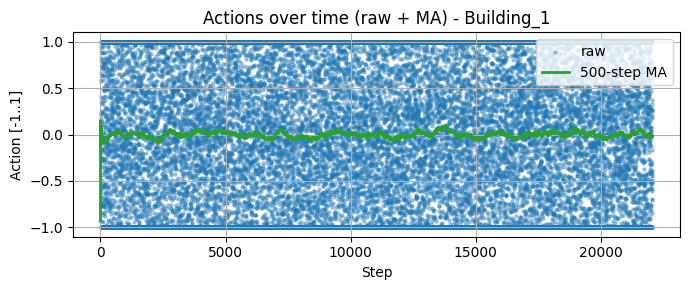

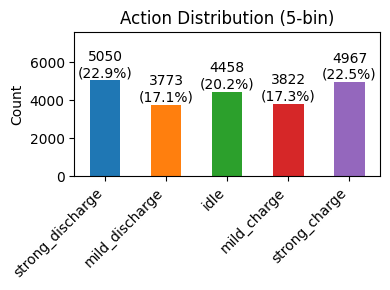

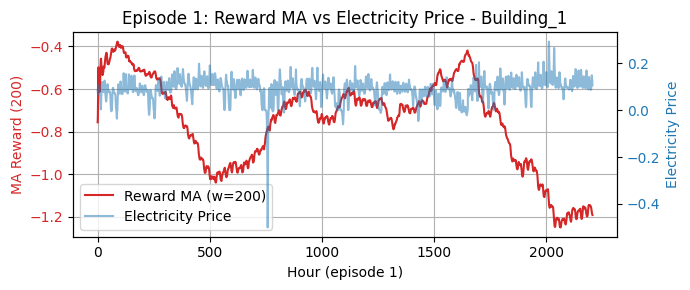

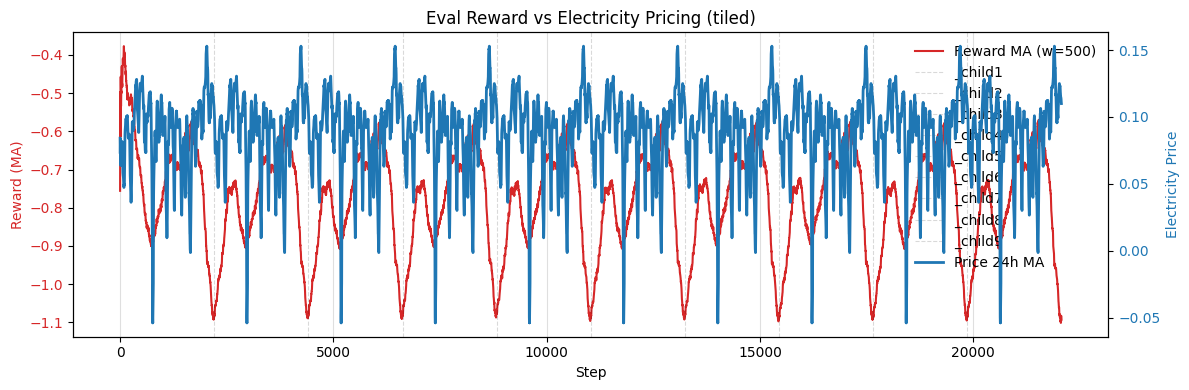

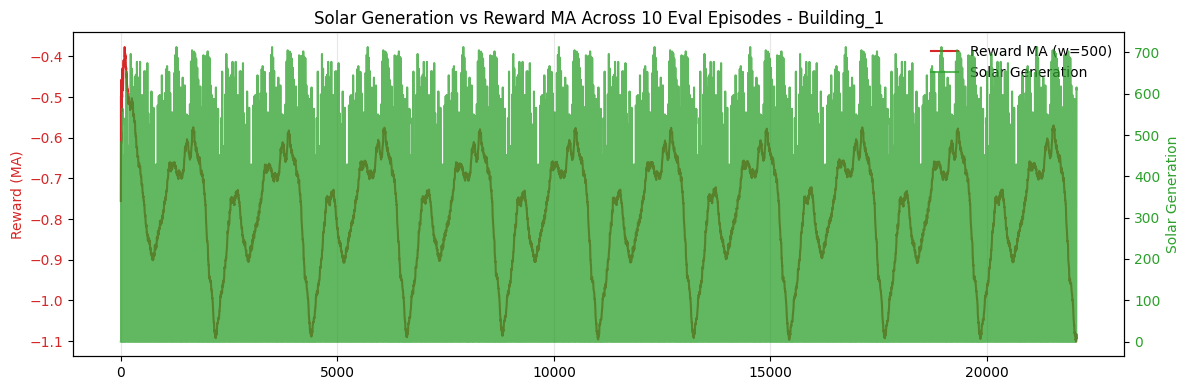

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
ACTION_LABELS = ['strong_discharge','mild_discharge','idle','mild_charge','strong_charge']
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def cont_to_label(vals):
    idx = np.argmin(np.abs(vals[..., None] - bin_centers[None, ...]), axis=-1)
    return idx  # 0..4

# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'{window}-step MA')
plt.title(f'Actions over time (raw + MA) - {building_name}')
plt.xlabel('Step'); plt.ylabel('Action [-1..1]'); plt.grid(True); plt.legend(loc='upper right')
plt.tight_layout(); plt.show()

# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
labels_idx = cont_to_label(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
plt.figure(figsize=(4,3))
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution (5-bin)'); plt.tight_layout(); plt.show()

# ----- Plot 3: Episode 1 Reward MA vs Electricity Price -----
# Recover episode-1 slice from flattened rewards
step_rewards_all = step_rewards_stoch  # already flattened across eval episodes
ep1_len = int(ep_lengths[0])
ep1_rewards = step_rewards_all[:ep1_len]
window_r = 200
ep1_reward_ma = pd.Series(ep1_rewards).rolling(window_r, min_periods=1).mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(7,3))
ax1.plot(np.arange(ep1_len), ep1_reward_ma, color='C3', label=f'Reward MA (w={window_r})')
ax1.set_ylabel(f'MA Reward ({window_r})', color='C3'); ax1.tick_params(axis='y', labelcolor='C3')
ax1.set_xlabel('Hour (episode 1)'); ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(prc.index[:ep1_len], prc['electricity_pricing'][:ep1_len], color='C0', alpha=0.5, label='Electricity Price')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')

lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='lower left')
plt.title(f'Episode 1: Reward MA vs Electricity Price - {building_name}')
plt.tight_layout(); plt.show()

# ----- Plot 4: Full-horizon Reward vs Electricity Price (tiled across episodes) -----
window_reward = 500
reward_ma = pd.Series(step_rewards_all).rolling(window_reward, min_periods=1).mean().to_numpy()
n_hours_total = len(step_rewards_all)
n_repeats = int(np.ceil(n_hours_total / T))
price_tiled = np.tile(prc['electricity_pricing'].values, n_repeats)[:n_hours_total]
price_ma = pd.Series(price_tiled).rolling(24, min_periods=1).mean().to_numpy()

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(np.arange(n_hours_total), reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
ax1.set_xlabel('Step'); ax1.set_ylabel('Reward (MA)', color='C3'); ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(np.arange(n_hours_total), price_ma, color='C0', lw=2, label='Price 24h MA')
ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')

# Mark episode boundaries
for off in ep_offsets[1:]:
    ax1.axvline(off, color='k', linestyle='--', alpha=0.15, linewidth=0.8)

lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title('Eval Reward vs Electricity Pricing (tiled)'); plt.tight_layout(); plt.show()

# ----- Plot 5: Solar Generation vs Reward MA Across Eval Episodes -----
# Load solar for chosen building
bld_file = schema['buildings'][building_name]['energy_simulation']
bld_path = os.path.join(ROOT_DIR, bld_file)
bld_df = pd.read_csv(bld_path)
solar_vals = bld_df['solar_generation'].values

solar_tiled = np.tile(solar_vals, int(np.ceil(n_hours_total / T)))[:n_hours_total]

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(np.arange(n_hours_total), reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
ax1.set_ylabel('Reward (MA)', color='C3'); ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(np.arange(n_hours_total), solar_tiled, color='C2', alpha=0.75, label='Solar Generation')
ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')

lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
plt.title(f'Solar Generation vs Reward MA Across {len(ep_lengths)} Eval Episodes - {building_name}')
plt.tight_layout(); plt.show()